In [1]:
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import gridspec
from matplotlib.cm import ScalarMappable

from data_utils import (
    get_absolute,
    get_anomaly,
    get_lat_weights,
    rescaled_weights,
    spatially_weighted_average,
)
from meteo_utils import kelvin_to_celsius
from plot_utils import add_headers

In [2]:
# plotting helper function
def add_label_to_axes(ax: mpl.axes.Axes, label, xpos=0.04, ypos=0.95):
    """Small helper function that adds a label to an Axes of a matplotlib plot.

    Args:
        ax (mpl.axes.Axes): A matplotlib axes.
        label (_type_): A label to add to the axes.
        xpos (float, optional): x position of the label. Defaults to 0.04.
        ypos (float, optional): y position of the label. Defaults to 0.95.

    """
    ax.text(
        xpos,
        ypos,
        label,
        ha="left",
        va="top",
        bbox={
            "facecolor": "white",
            "edgecolor": "none",
            "boxstyle": "square",
            "pad": 0.1,
        },
        transform=ax.transAxes,
    )


letters = ["A", "B", "C", "D", "E", "F", "G"]

In [3]:
# plotting config

plt.rcParams.update({"font.size": 8})
plt.rcParams["figure.dpi"] = 300
plt.style.use("tableau-colorblind10")

alphabet_letters = np.array(
    list(map(chr, range(65, 91)))
)  # used for labelling subplots
textwidth = 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch  # textwidth in inches

In [4]:
# locations of three mayor population centers
lats = np.array([49.25, 47.5, 45.5])
lons = np.array([-123, -122.25, -122.75]) % 360
labels = ["Vancouver", "Seattle", "Portland"]

# the entire lat/lon grid - we only saved a cropped version in the preprocessed data.
grid = xr.DataArray(
    dims=("latitude", "longitude"),
    coords={
        "latitude": np.arange(-90, 90.25, 0.25),
        "longitude": np.arange(0, 360, 0.25),
    },
)

# event range to be analyzed
ts = slice(
    np.datetime64("2021-06-27T00:00:00.000000000"),
    np.datetime64("2021-06-29T23:59:00.000000000"),
)

forecast_horizon_days = 10

In [5]:
# load preprocessed data.
gt_data = xr.open_dataset("data/2021_PNW_heatwave_gt.nc")
fc_data = xr.open_dataset("data/2021_PNW_heatwave_fc.nc")

era5_climatology = xr.open_dataset("data/2021_PNW_heatwave_climatology.nc")

## Single Panel ERA5 (for visualisation)

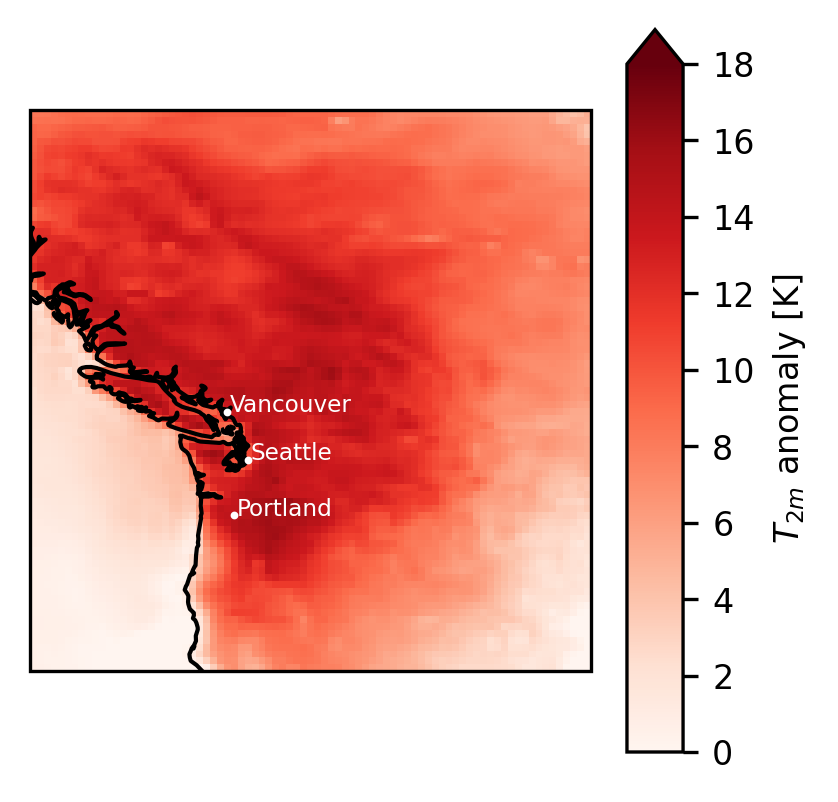

In [6]:
levels = np.arange(-18, 20, 2)

aspect_ratio_single_plot = 1
fig = plt.figure(figsize=(textwidth / 2, textwidth / 2 / aspect_ratio_single_plot))
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=(1, 0.1))

anomaly_ERA5 = get_anomaly(
    da=gt_data.sel(source="ERA5")["2m_temperature"], climatology=era5_climatology, ts=ts
)

ax_era5 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot(ax=ax_era5, add_colorbar=False, cmap="Reds", vmin=0, vmax=18)
)

ax_era5.coastlines()
ax_era5.set_title("")

ax_era5.scatter(
    lons,
    lats,
    transform=ccrs.PlateCarree(),
    c="w",
    marker=".",
    s=3,
    zorder=np.inf,
)

for i, text in enumerate(labels):
    ax_era5.annotate(
        text,
        (lons[i] + 0.1, lats[i]),
        transform=ccrs.PlateCarree(),
        fontsize="x-small",
        color="white",
        zorder=np.inf,
    )

ax_cbar = fig.add_subplot(gs[0, 1])

plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{2m}$ anomaly [K]",
    orientation="vertical",
    extend="max",
)

fig.suptitle("")
plt.tight_layout()
plt.savefig("images/2021_PNW_heatwave_anomalies_visual.png")
plt.show()

## comparing predicted anomalies:

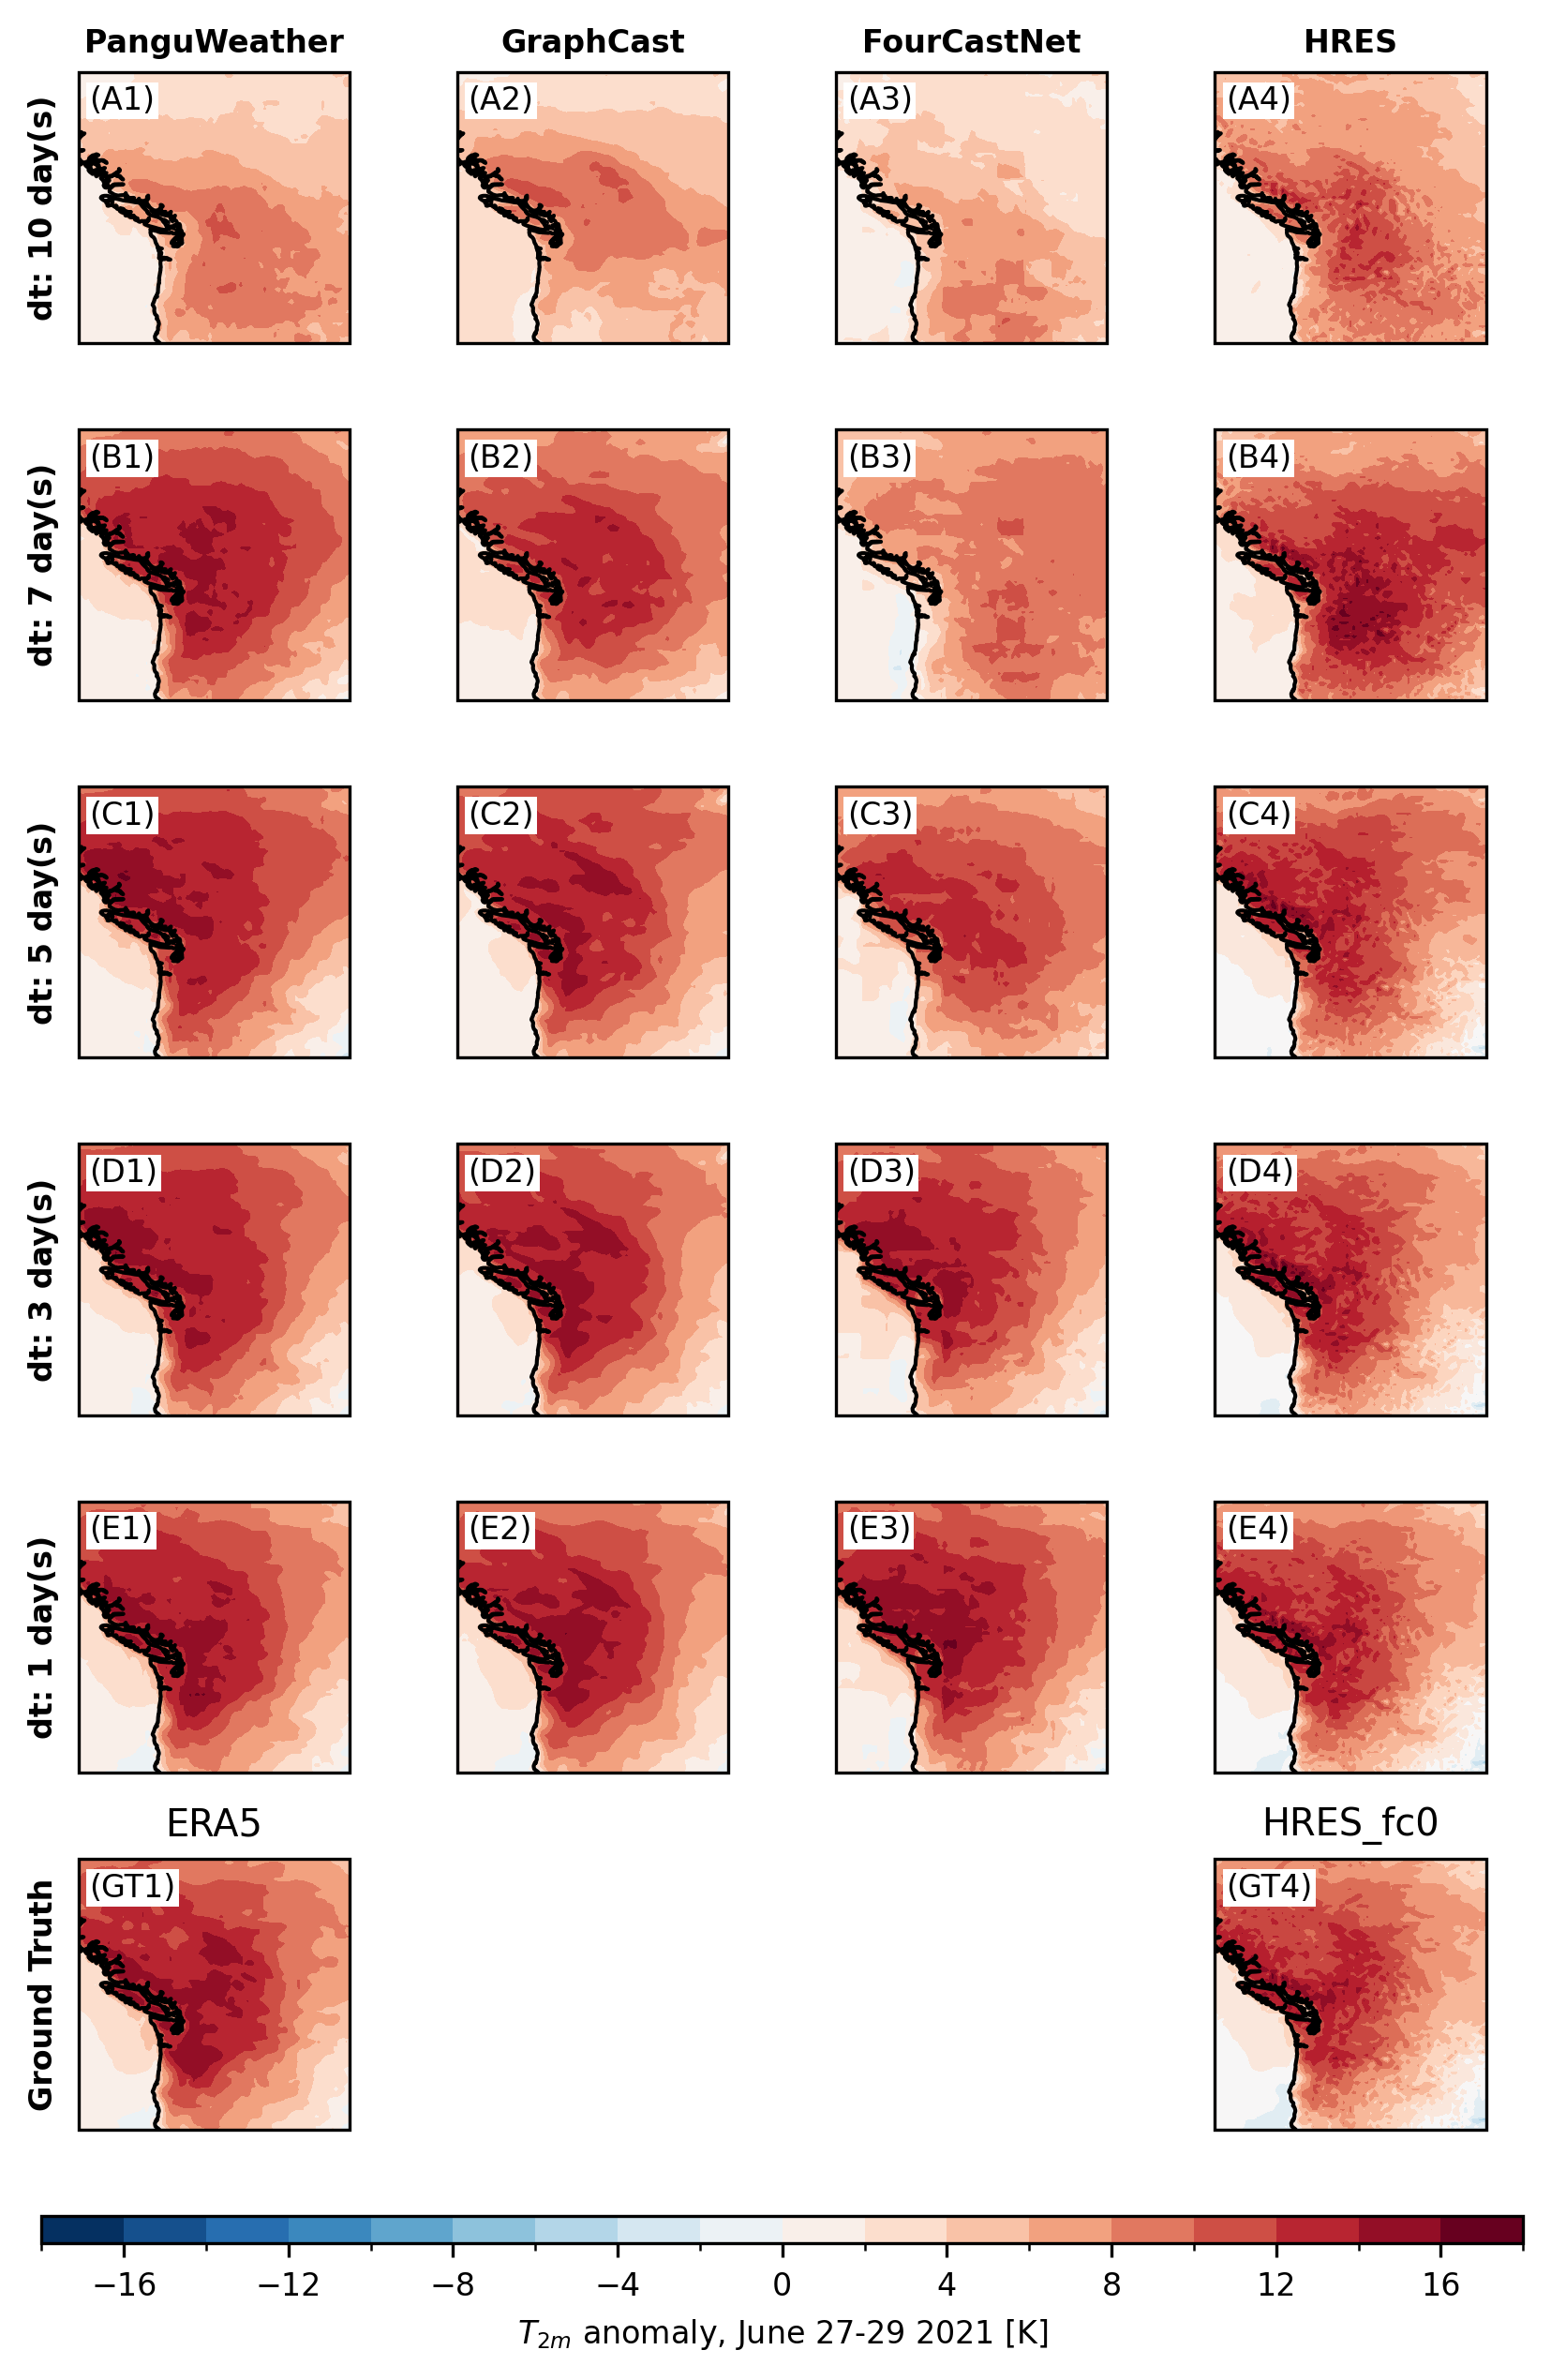

In [7]:
lts = list(reversed([1, 3, 5, 7, 10]))

levels = np.arange(-18, 20, 2)

aspect_ratio_single_plot = 1
fig = plt.figure(
    figsize=(textwidth, textwidth / aspect_ratio_single_plot * (len(lts) + 1) / 4)
)
gs = gridspec.GridSpec(
    len(lts) + 2, 4, figure=fig, height_ratios=(len(lts) + 1) * [1] + [0.1]
)

anomaly_ERA5 = get_anomaly(
    da=gt_data.sel(source="ERA5")["2m_temperature"], climatology=era5_climatology, ts=ts
)
anomaly_hres_t0 = get_anomaly(
    da=gt_data.sel(source="HRES_t0")["2m_temperature"],
    climatology=era5_climatology,
    ts=ts,
)

ax_era5 = fig.add_subplot(gs[-2, 0], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot.contourf(ax=ax_era5, levels=levels, add_colorbar=False, cmap="RdBu_r")
)

ax_hres_t0 = fig.add_subplot(gs[-2, 3], projection=ccrs.PlateCarree())
anomaly_hres_t0["2m_temperature"].mean(dim=("hour", "dayofyear")).plot.contourf(
    ax=ax_hres_t0, levels=levels, add_colorbar=False, cmap="RdBu_r"
)

ax_era5.coastlines()
ax_hres_t0.coastlines()

ax_era5.set_title("ERA5")
ax_hres_t0.set_title("HRES_fc0")

add_label_to_axes(ax_era5, "(GT1)")
add_label_to_axes(ax_hres_t0, "(GT4)")

for i, lt in enumerate(lts):
    for j, fc in enumerate(fc_data.forecast):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        anomaly = get_anomaly(
            da=fc_data.sel(forecast=fc)["2m_temperature"].drop_vars("valid_time"),
            climatology=era5_climatology["2m_temperature"],
            ts=ts,
            lead_time=lt,
        )

        anomaly.mean(dim=("hour", "dayofyear")).plot.contourf(
            ax=ax, add_colorbar=False, levels=levels, cmap="RdBu_r"
        )

        ax.coastlines()
        ax.set_title("")

        if j == 0:
            ax.set_ylabel("test")
        add_label_to_axes(ax, f"({letters[i]}{j+1})")

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{2m}$ anomaly, June 27-29 2021 [K]",
    orientation="horizontal",
    extend="both",
)

add_headers(
    fig=fig,
    col_headers=fc_data.forecast.values,
    row_headers=[f"dt: {lt} day(s)" for lt in lts] + ["Ground Truth"] + [""],
    fontweight="bold",
)

plt.tight_layout()
plt.savefig("images/2021_PNW_heatwave_anomalies_temporally_accumulated.png")
plt.show()

same plot but with fixed starting date.

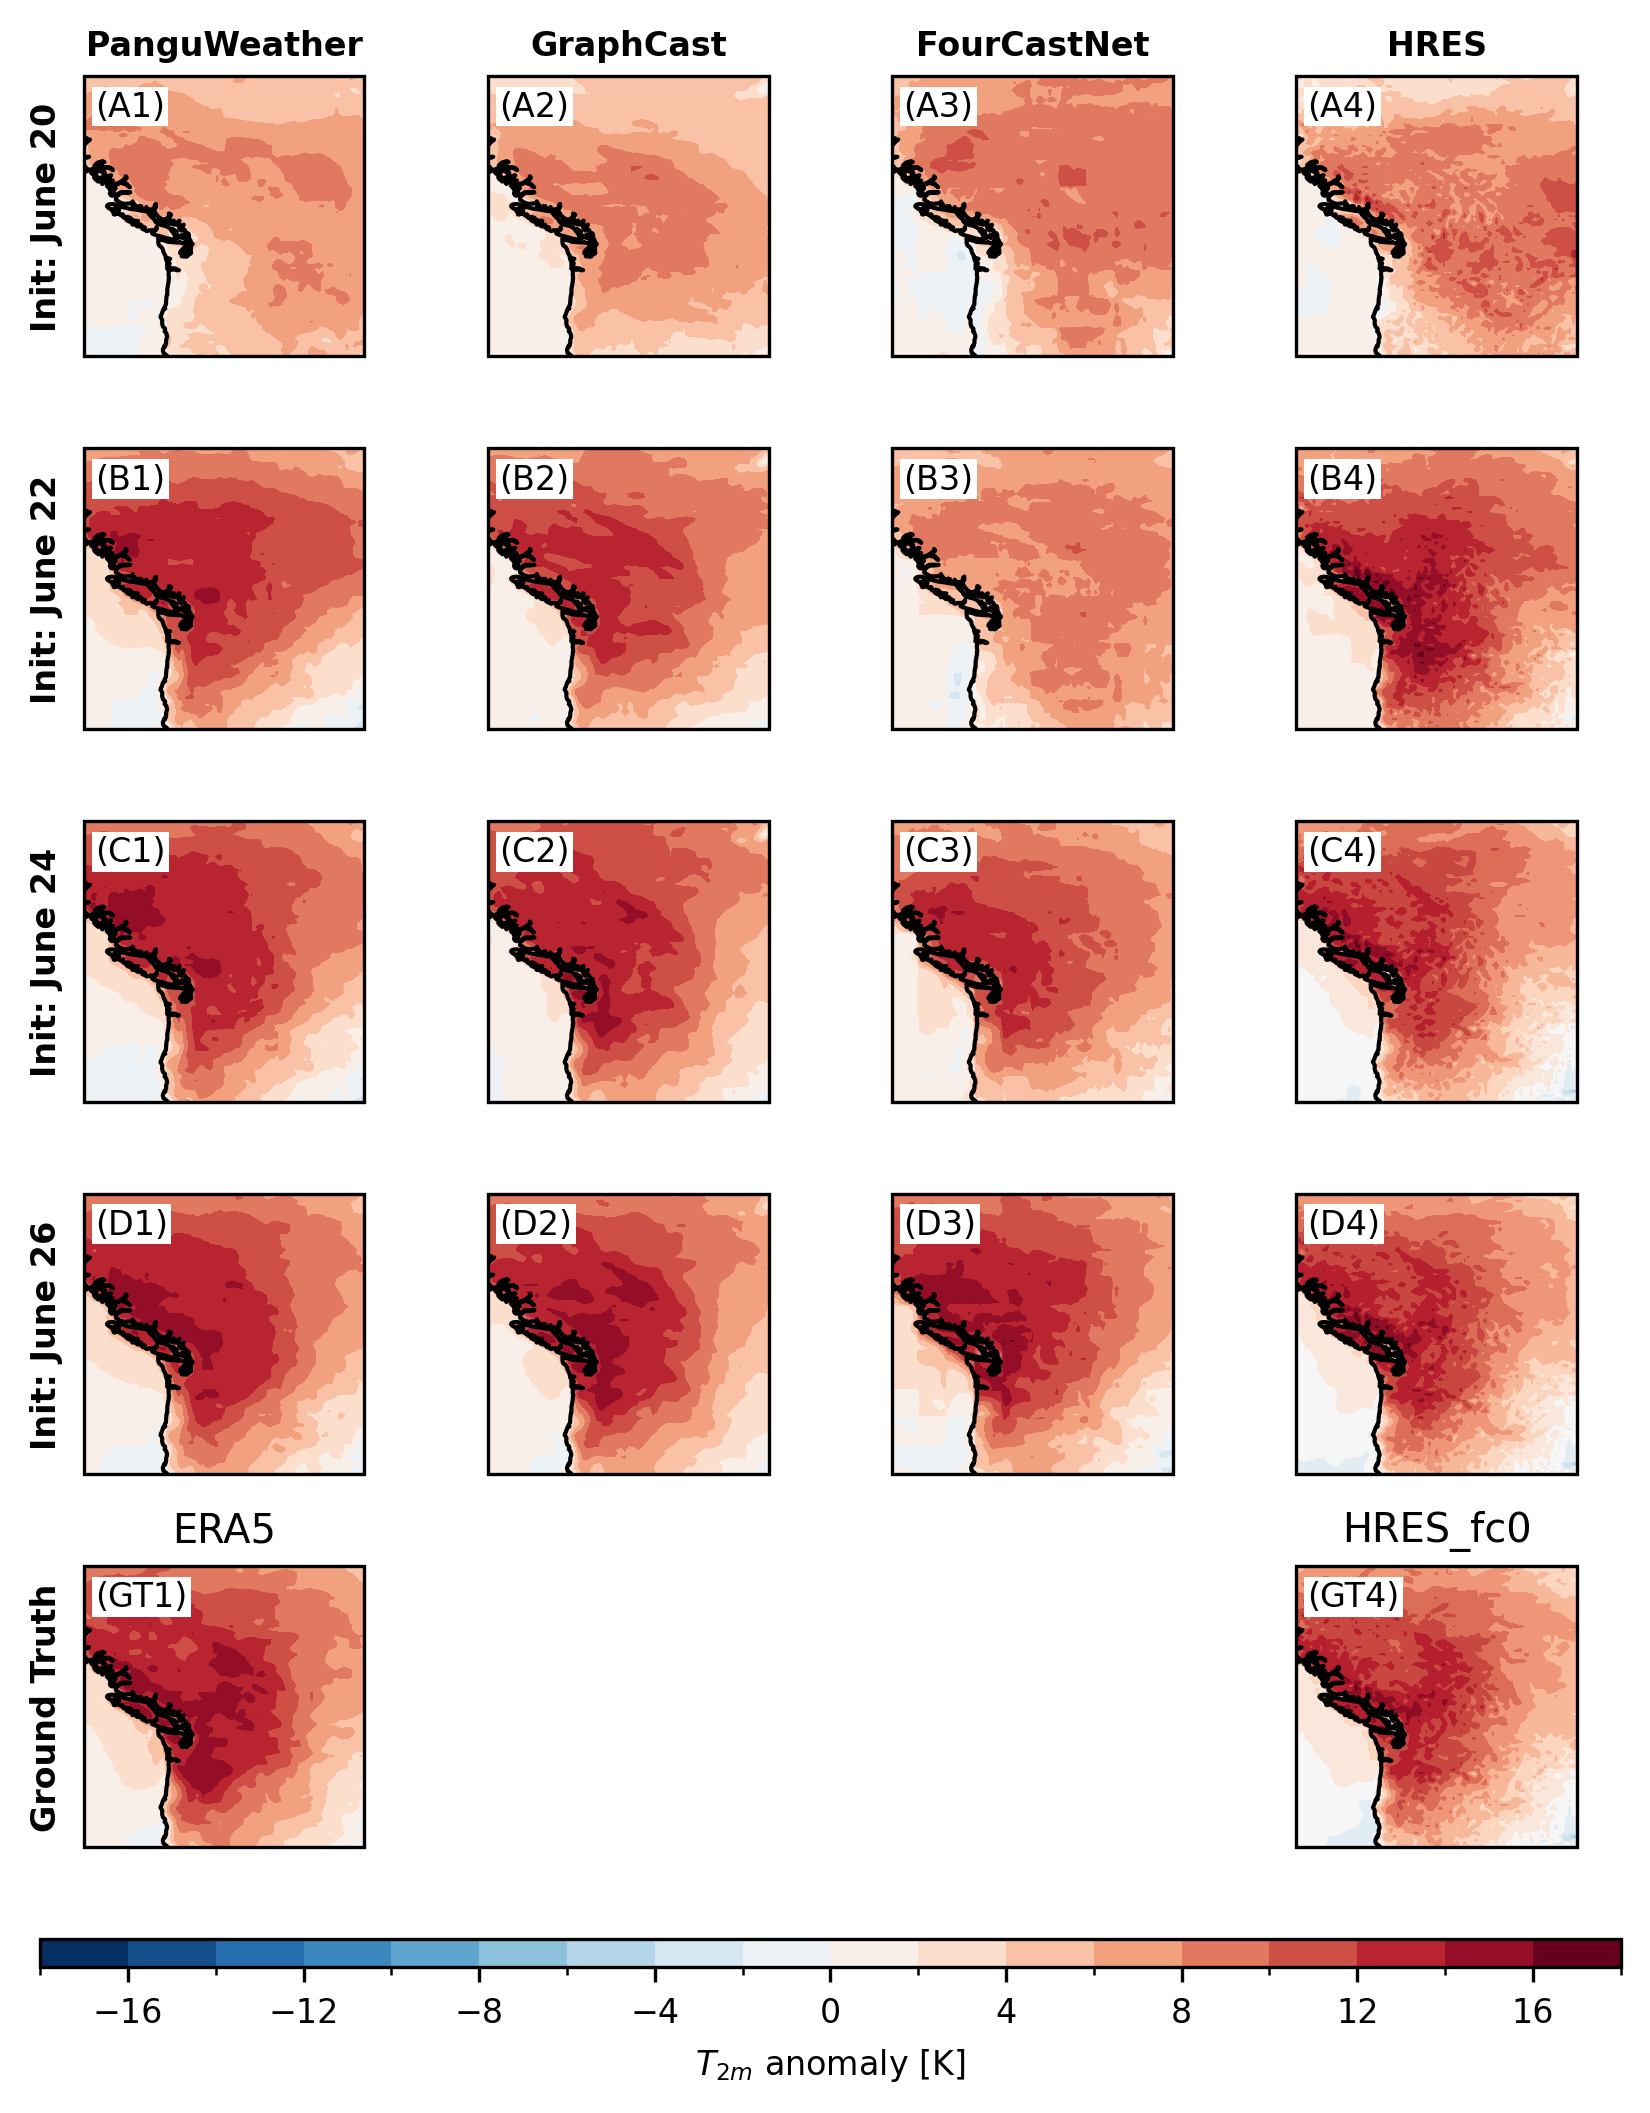

In [8]:
start_dates = ts.start - np.flip(np.array([1, 3, 5, 7])) * np.timedelta64(1, "D")

levels = np.arange(-18, 20, 2)

aspect_ratio_single_plot = 1
fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(start_dates) + 1) / 4,
    )
)
gs = gridspec.GridSpec(
    len(start_dates) + 2,
    4,
    figure=fig,
    height_ratios=(len(start_dates) + 1) * [1] + [0.1],
)

anomaly_ERA5 = get_anomaly(
    da=gt_data.sel(source="ERA5")["2m_temperature"], climatology=era5_climatology, ts=ts
)
anomaly_hres_t0 = get_anomaly(
    da=gt_data.sel(source="HRES_t0")["2m_temperature"],
    climatology=era5_climatology,
    ts=ts,
)

ax_era5 = fig.add_subplot(gs[-2, 0], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot.contourf(ax=ax_era5, levels=levels, add_colorbar=False, cmap="RdBu_r")
)

ax_hres_t0 = fig.add_subplot(gs[-2, 3], projection=ccrs.PlateCarree())
anomaly_hres_t0["2m_temperature"].mean(dim=("hour", "dayofyear")).plot.contourf(
    ax=ax_hres_t0, levels=levels, add_colorbar=False, cmap="RdBu_r"
)

ax_era5.coastlines()
ax_hres_t0.coastlines()

ax_era5.set_title("ERA5")
ax_hres_t0.set_title("HRES_fc0")

add_label_to_axes(ax_era5, "(GT1)")
add_label_to_axes(ax_hres_t0, "(GT4)")

for i, start_date in enumerate(start_dates):
    for j, fc in enumerate(fc_data.forecast):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        anomaly = get_anomaly(
            da=fc_data.sel(forecast=fc)["2m_temperature"].drop_vars("valid_time"),
            climatology=era5_climatology["2m_temperature"],
            ts=ts,
            start_date=start_date,
        )

        anomaly.mean(dim=("hour", "dayofyear")).plot.contourf(
            ax=ax, add_colorbar=False, levels=levels, cmap="RdBu_r"
        )

        ax.coastlines()
        ax.set_title("")  # "{fc.values} \n Lead time {lt} day(s)")

        if j == 0:
            ax.set_ylabel("test")
        add_label_to_axes(ax, f"({letters[i]}{j+1})")

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{2m}$ anomaly [K]",
    orientation="horizontal",
    extend="both",
)

add_headers(
    fig=fig,
    col_headers=fc_data.forecast.values,
    row_headers=[
        f"Init: {pd.Timestamp(sd).date().strftime('%B %d')}" for sd in start_dates
    ]
    + ["Ground Truth"]
    + [""],
    fontweight="bold",
)

plt.tight_layout()
plt.savefig("images/2021_PNW_heatwave_anomalies_temporally_accumulated_start_dates.png")
plt.show()

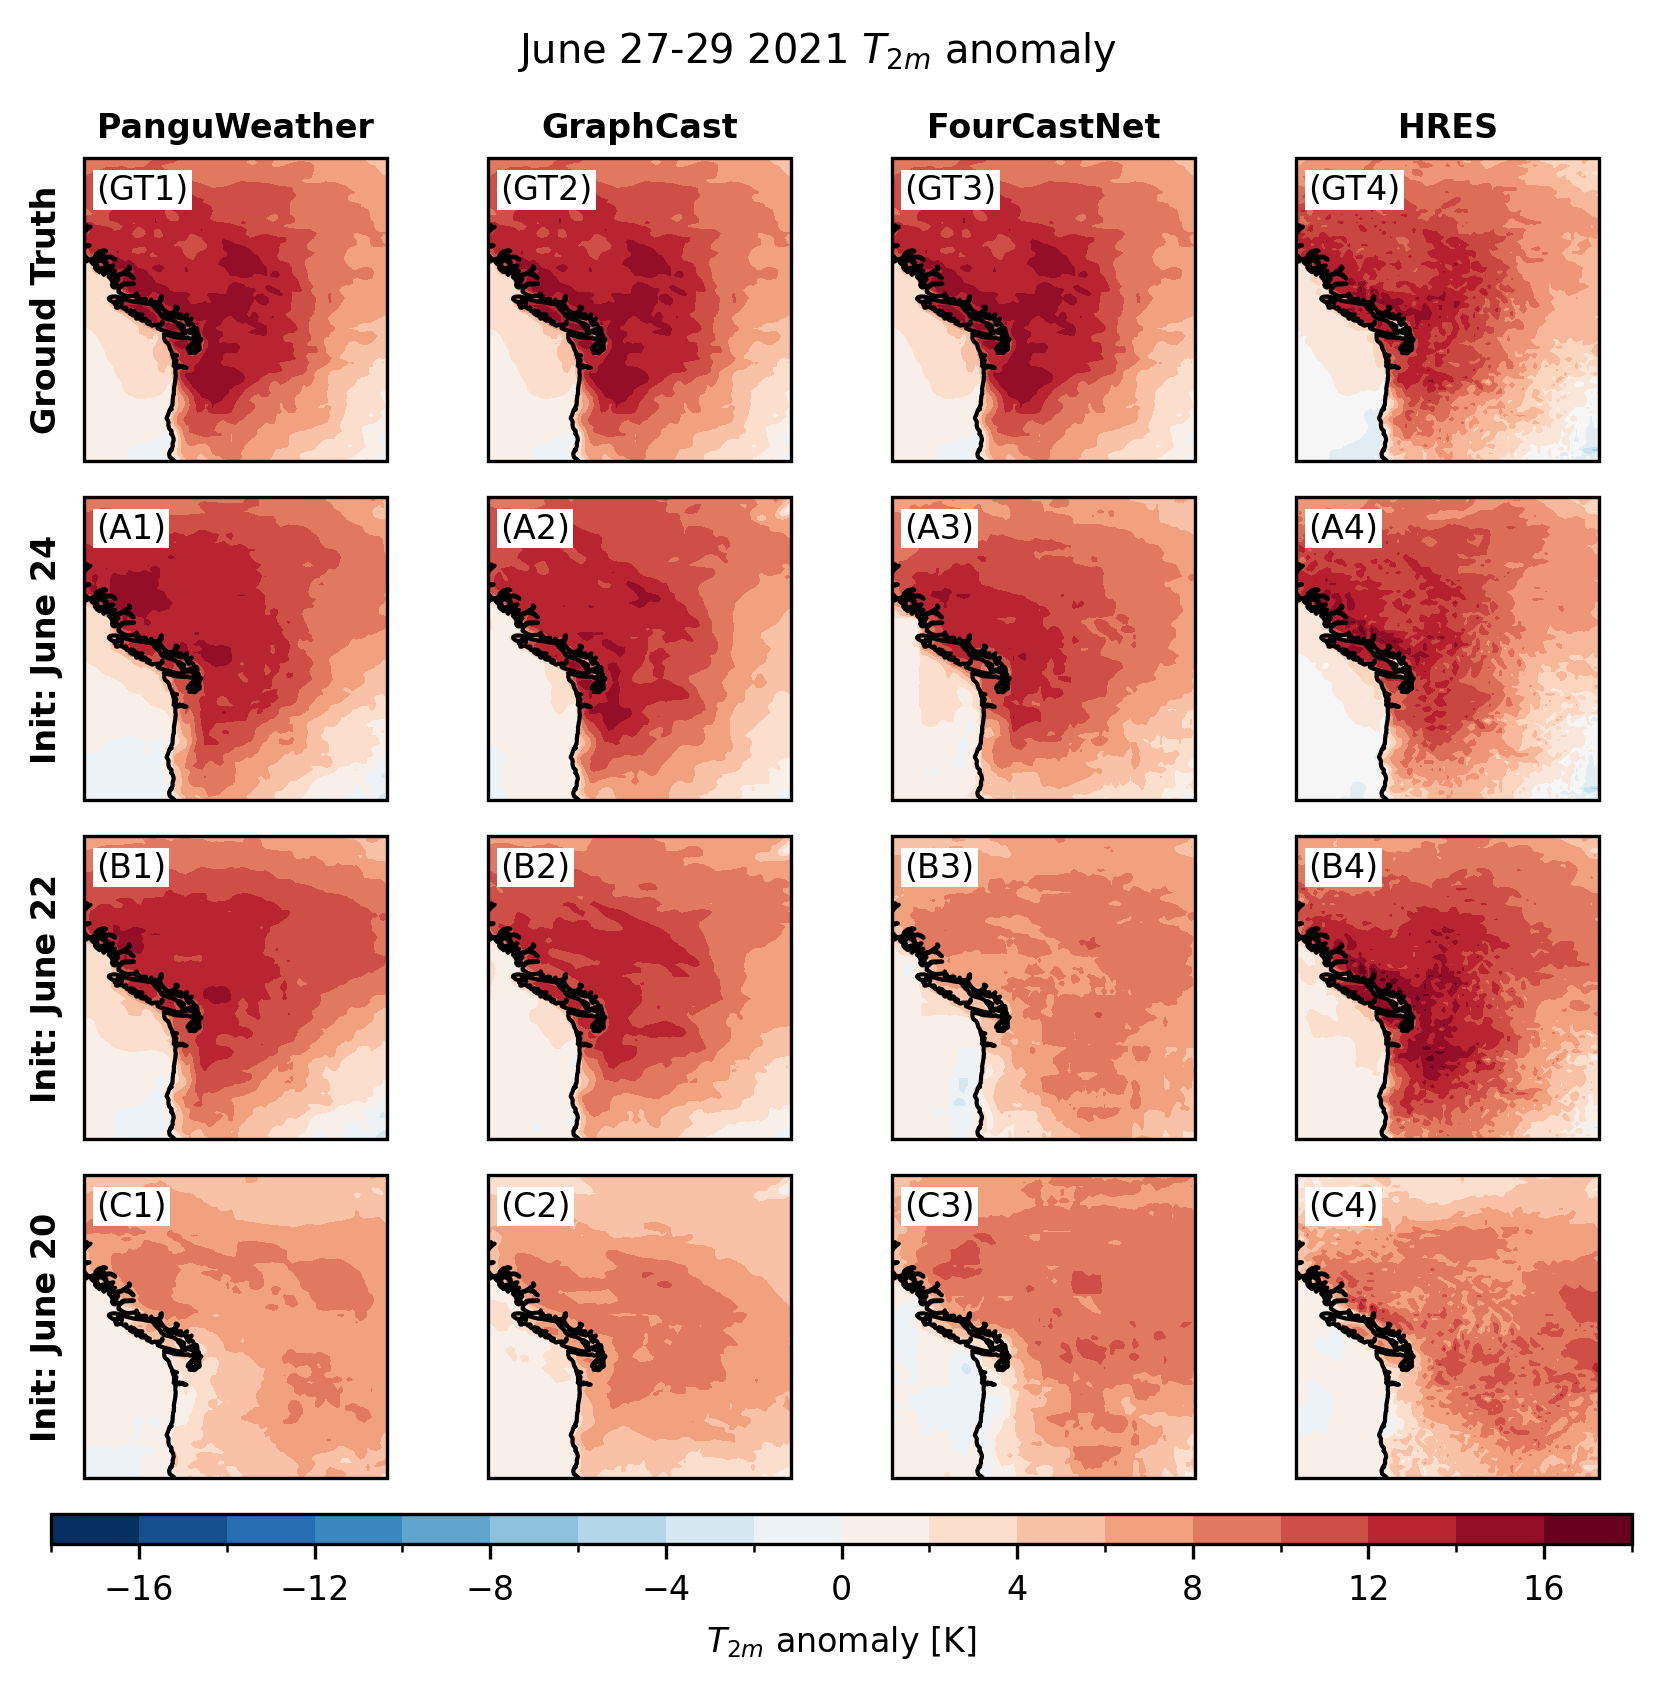

In [9]:
start_dates = ts.start - np.flip(np.array([3, 5, 7])) * np.timedelta64(1, "D")

levels = np.arange(-18, 20, 2)

aspect_ratio_single_plot = 1
fig = plt.figure(
    figsize=(
        textwidth,
        textwidth / aspect_ratio_single_plot * (len(start_dates) + 1) / 4,
    )
)
gs = gridspec.GridSpec(
    len(start_dates) + 2,
    4,
    figure=fig,
    height_ratios=(len(start_dates) + 1) * [1] + [0.1],
)

anomaly_ERA5 = get_anomaly(
    da=gt_data.sel(source="ERA5")["2m_temperature"], climatology=era5_climatology, ts=ts
)
anomaly_hres_t0 = get_anomaly(
    da=gt_data.sel(source="HRES_t0")["2m_temperature"],
    climatology=era5_climatology,
    ts=ts,
)

ax_era5_0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot.contourf(ax=ax_era5_0, levels=levels, add_colorbar=False, cmap="RdBu_r")
)

ax_era5_1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot.contourf(ax=ax_era5_1, levels=levels, add_colorbar=False, cmap="RdBu_r")
)

ax_era5_2 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot.contourf(ax=ax_era5_2, levels=levels, add_colorbar=False, cmap="RdBu_r")
)

ax_hres_t0 = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
anomaly_hres_t0["2m_temperature"].mean(dim=("hour", "dayofyear")).plot.contourf(
    ax=ax_hres_t0, levels=levels, add_colorbar=False, cmap="RdBu_r"
)

ax_era5_0.coastlines()
ax_era5_1.coastlines()
ax_era5_2.coastlines()
ax_hres_t0.coastlines()

ax_era5_0.set_title("")
ax_era5_1.set_title("")
ax_era5_2.set_title("")
ax_hres_t0.set_title("")

add_label_to_axes(ax_era5_0, "(GT1)")
add_label_to_axes(ax_era5_1, "(GT2)")
add_label_to_axes(ax_era5_2, "(GT3)")
add_label_to_axes(ax_hres_t0, "(GT4)")

for i, start_date in enumerate(start_dates):
    for j, fc in enumerate(fc_data.forecast):
        ax = fig.add_subplot(gs[len(start_dates) - i, j], projection=ccrs.PlateCarree())
        anomaly = get_anomaly(
            da=fc_data.sel(forecast=fc)["2m_temperature"].drop_vars("valid_time"),
            climatology=era5_climatology["2m_temperature"],
            ts=ts,
            start_date=start_date,
        )

        anomaly.mean(dim=("hour", "dayofyear")).plot.contourf(
            ax=ax, add_colorbar=False, levels=levels, cmap="RdBu_r"
        )

        ax.coastlines()
        ax.set_title("")  # "{fc.values} \n Lead time {lt} day(s)")

        if j == 0:
            ax.set_ylabel("test")

        add_label_to_axes(ax, f"({letters[2-i]}{j+1})")

ax_cbar = fig.add_subplot(gs[-1, :])
plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{2m}$ anomaly [K]",
    orientation="horizontal",
    extend="both",
)

add_headers(
    fig=fig,
    col_headers=fc_data.forecast.values,
    row_headers=["Ground Truth"]
    + [
        f"Init: {pd.Timestamp(sd).date().strftime('%B %d')}"
        for sd in reversed(start_dates)
    ]
    + [""],
    fontweight="bold",
)


fig.suptitle("June 27-29 2021 $T_{2m}$ anomaly")
plt.tight_layout()
plt.savefig(
    "images/2021_PNW_heatwave_anomalies_temporally_accumulated_start_dates_small.png"
)
plt.show()

### Spatial analysis:

- use ERA5 heat anomaly to find a region with especially high anomaly.
- look at absolute temperatures (otherwise unfair comparison for HRES)
- take spatially weighted mean
- take mean over three days in event

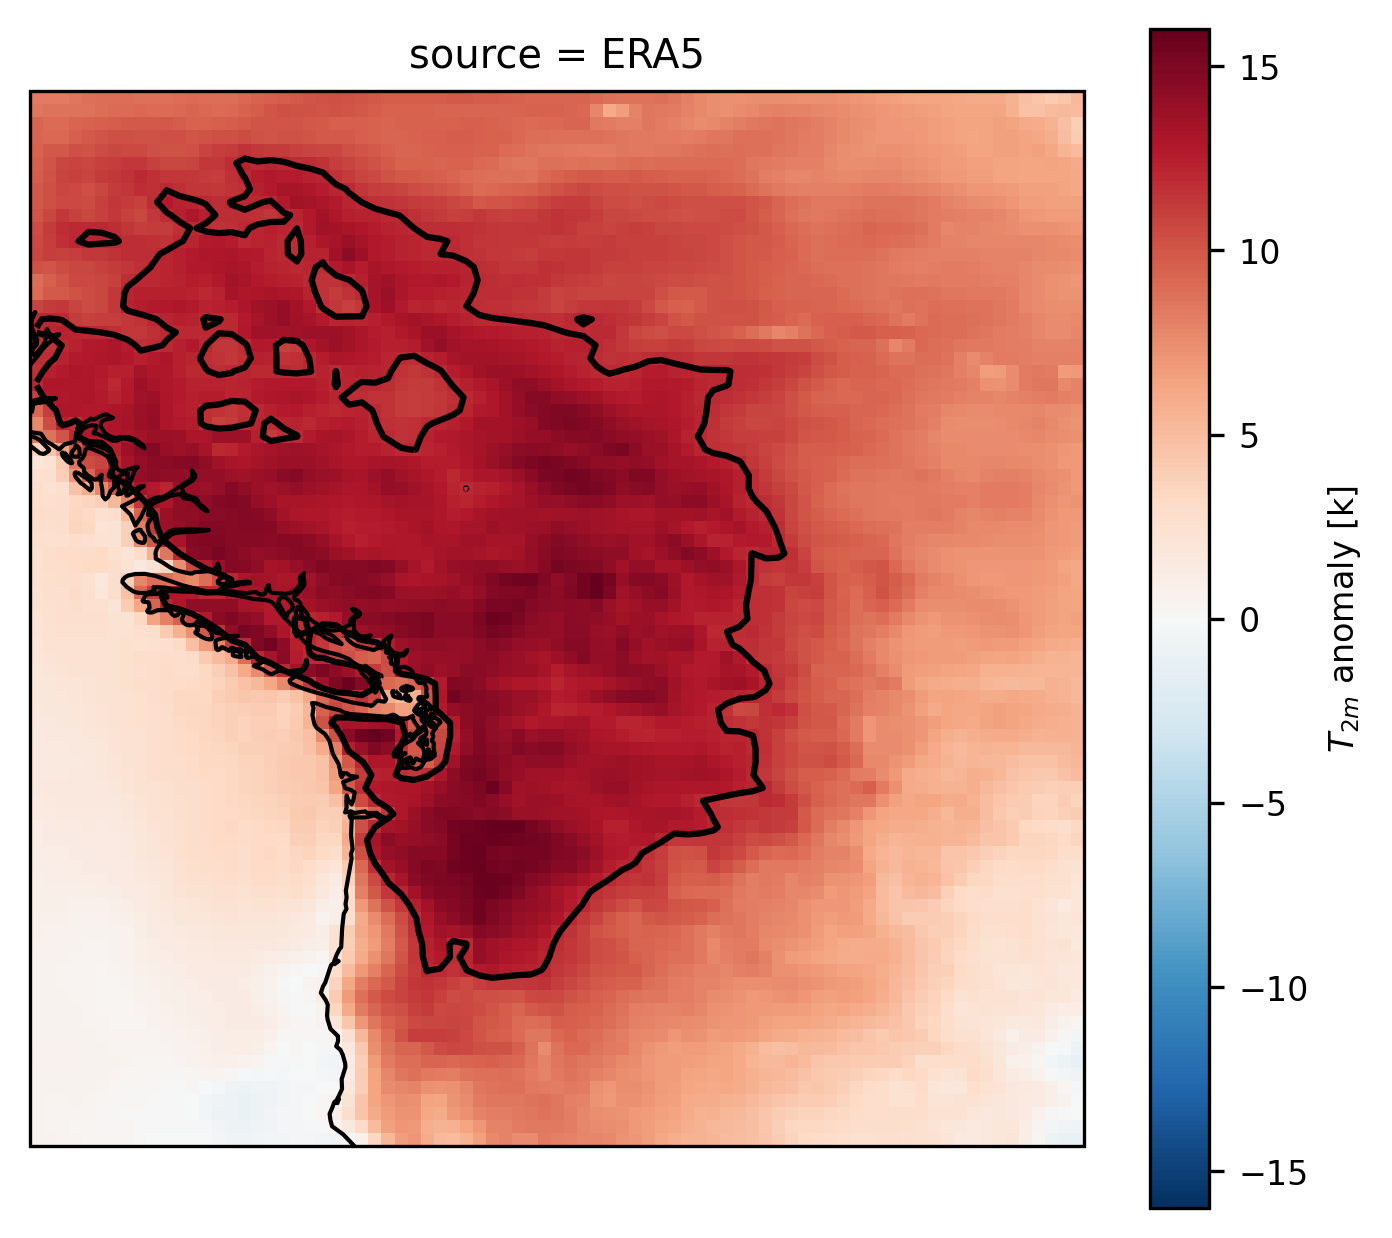

In [10]:
fig, axis = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

fig.set_size_inches(textwidth, 0.9 * textwidth)

threshold = 12

anomaly_ERA5["2m_temperature"].mean(dim=("hour", "dayofyear")).plot.contour(
    ax=axis, colors=["k"], levels=[threshold]
)

anomaly_ERA5["2m_temperature"].mean(dim=("hour", "dayofyear")).plot(
    ax=axis,
    alpha=1,
    cmap="RdBu_r",
    vmin=-16,
    vmax=16,
    cbar_kwargs={"label": "$T_{2m}$ anomaly [k]"},
)

axis.coastlines()

plt.savefig("images/2021_PNW_heatwave_contour.png")

In [11]:
mask = anomaly_ERA5["2m_temperature"].mean(dim=("hour", "dayofyear")) > threshold

w = get_lat_weights(grid)
area_weights = rescaled_weights(w, grid.longitude)

weighted average:

$m = \frac{\sum x_i w_i}{\sum w_i}$

In [12]:
start_dates = ts.start - np.arange(1, 29) * np.timedelta64(6, "h")

t_ERA5 = get_absolute(gt_data.sel(source="ERA5")["2m_temperature"], ts=ts)
m_ERA5 = kelvin_to_celsius(spatially_weighted_average(t_ERA5, area_weights, mask))

t_hres_t0 = get_absolute(gt_data.sel(source="HRES_t0")["2m_temperature"], ts=ts)
m_hres_t0 = kelvin_to_celsius(spatially_weighted_average(t_hres_t0, area_weights, mask))

m_fcs = np.empty((len(start_dates), len(fc_data.forecast)))

for i, start_date in enumerate(start_dates):
    for j, fc in enumerate(fc_data.forecast):
        t = get_absolute(
            fc_data.sel(forecast=fc)["2m_temperature"].drop_vars("valid_time"),
            start_date=start_date,
            ts=ts,
        )

        m_fcs[i, j] = kelvin_to_celsius(
            spatially_weighted_average(t, area_weights, mask)
        )
m_fcs = xr.DataArray(
    data=m_fcs,
    coords={
        "start_date": ("start_date", start_dates),
        "forecast": ("forecast", fc_data.forecast.data),
    },
)

In [13]:
fc_to_gt = {
    "PanguWeather": "ERA5",
    "FourCastNet": "ERA5",
    "GraphCast": "ERA5",
    "HRES": "HRES_t0",
}
gts = {"HRES_t0": m_hres_t0, "ERA5": m_ERA5}

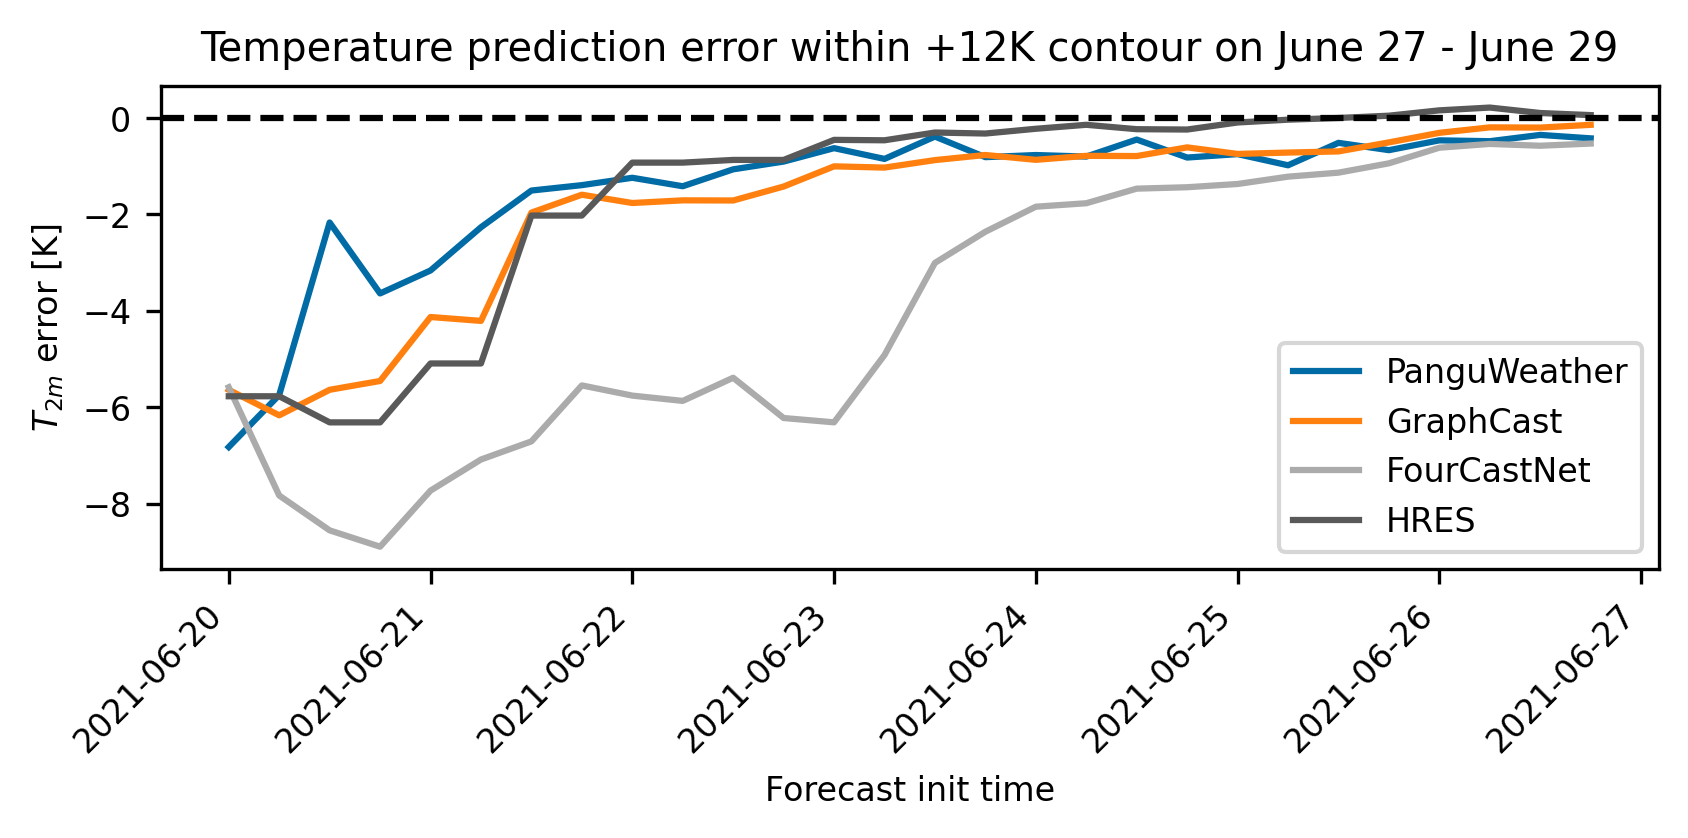

In [14]:
plt.figure(figsize=(textwidth, 0.5 * textwidth))

for fc in m_fcs.forecast:
    plt.plot(
        start_dates,
        m_fcs.sel(forecast=fc) - gts[fc_to_gt[fc.to_numpy().item()]],
        label=fc.to_numpy(),
    )

plt.axhline(0, color="k", linestyle="dashed")

plt.xticks(rotation=45, ha="right")

plt.xlabel("Forecast init time")
plt.ylabel("$T_{2m}$ error [K]")

plt.title("Temperature prediction error within +12K contour on June 27 - June 29")

plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/2021_PNW_heatwave_mean_temperature_within_contour_anomalies.png")

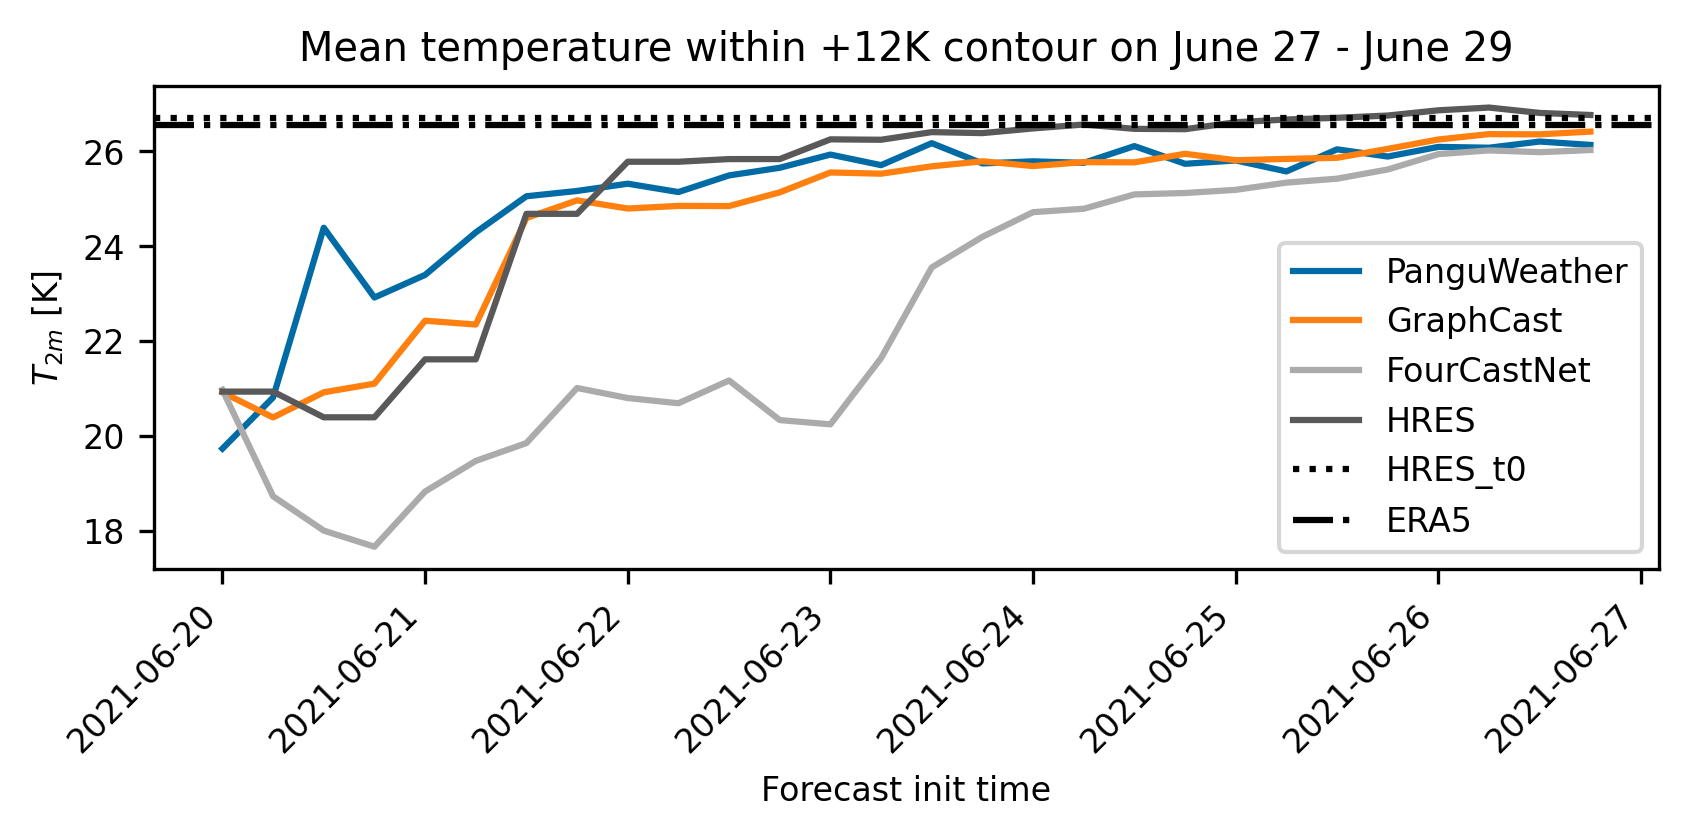

In [15]:
plt.figure(figsize=(textwidth, 0.5 * textwidth))

for fc in m_fcs.forecast:
    plt.plot(start_dates, m_fcs.sel(forecast=fc), label=fc.values)

plt.axhline(m_hres_t0, label="HRES_t0", linestyle="dotted", color="k")
plt.axhline(m_ERA5, label="ERA5", linestyle="-.", color="k")
plt.xticks(rotation=45, ha="right")

plt.xlabel("Forecast init time")
plt.ylabel("$T_{2m}$ [K]")

plt.title("Mean temperature within +12K contour on June 27 - June 29")

plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/2021_PNW_heatwave_mean_temperature_within_contour.png")

Differences in results might be because of the projected heat being to small - or it being predicted in the wrong location. To test this, we can plot the anomaly contours for GraphCast and Pangu (and HRES, knowing it's not quite a fair comparison)

In [16]:
start_dates = ts.start - np.arange(1, 15) * np.timedelta64(12, "h")

anomaly = xr.DataArray(
    coords={
        "start_date": ("start_date", start_dates),
        "forecast": ("forecast", fc_data.forecast.data),
        "latitude": ("latitude", fc_data.latitude.data),
        "longitude": ("longitude", fc_data.longitude.data),
    },
    dims=("start_date", "forecast", "latitude", "longitude"),
)


for fc in fc_data.forecast:
    for start_date in start_dates:
        anomaly.loc[{"start_date": start_date, "forecast": fc}] = get_anomaly(
            da=fc_data.sel(forecast=fc)["2m_temperature"].drop_vars("valid_time"),
            climatology=era5_climatology["2m_temperature"],
            ts=ts,
            start_date=start_date,
        ).mean(dim=("hour", "dayofyear"))

In [17]:
cmap = plt.cm.cividis  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

bounds = np.linspace(0, 100, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sm = ScalarMappable(cmap=cmap, norm=norm)

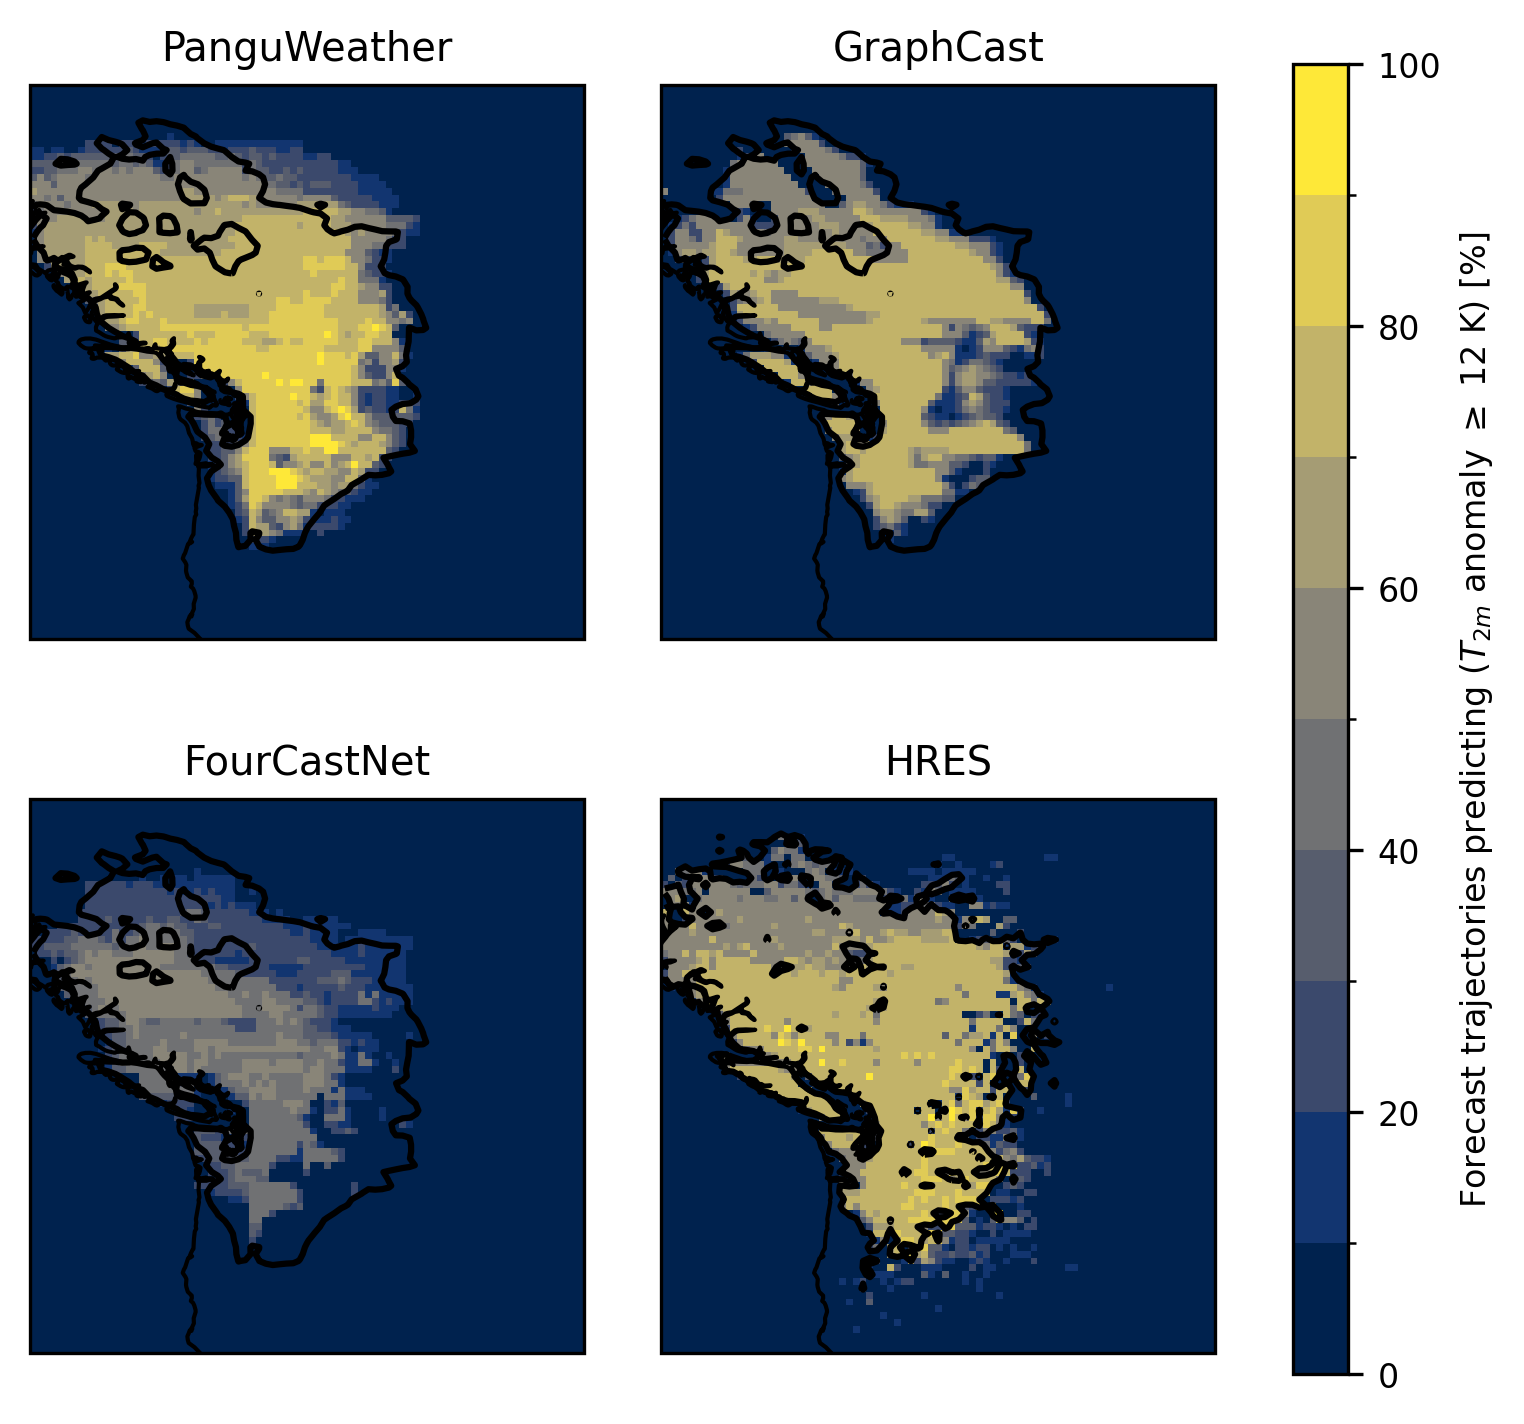

In [18]:
aspect_ratio_single_plot = 1
fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot))
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.1])

for j, fc in enumerate(fc_data.forecast):
    ax = fig.add_subplot(gs[j // 2, j % 2], projection=ccrs.PlateCarree())
    (
        100
        * (anomaly >= threshold).sum("start_date").sel(forecast=fc)
        / len(anomaly.start_date)
    ).plot(cmap=cmap, norm=norm, add_colorbar=False)

    if fc == "HRES":
        anomaly_hres_t0.mean(dim=("dayofyear", "hour"))["2m_temperature"].plot.contour(
            ax=ax, levels=[threshold], colors=["k"]
        )
    else:
        anomaly_ERA5.mean(dim=("dayofyear", "hour"))["2m_temperature"].plot.contour(
            ax=ax, levels=[threshold], colors=["k"]
        )
    ax.set_title(fc.values)
    ax.coastlines()

ax_cbar = fig.add_subplot(gs[:, -1])

plt.colorbar(
    sm,
    cax=ax_cbar,
    label=r"Forecast trajectories predicting ($T_{2m}$ anomaly $\geq$ 12 K) [%]",
    orientation="vertical",
    extend="neither",
)
plt.savefig("images/2021_PNW_heatwave_contour_evolution_alternative.png")

In [19]:
start_dates = ts.start - np.arange(1, 8) * np.timedelta64(24, "h")

In [20]:
colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d"]

ticks = np.linspace(0, 1, 15)[1::2]
cbar_labels = [str(pd.Timestamp(dt).date()) for dt in start_dates]

cmap = plt.get_cmap(mpl.colors.ListedColormap(colors), len(colors))
sm = ScalarMappable(cmap=cmap, norm=None)

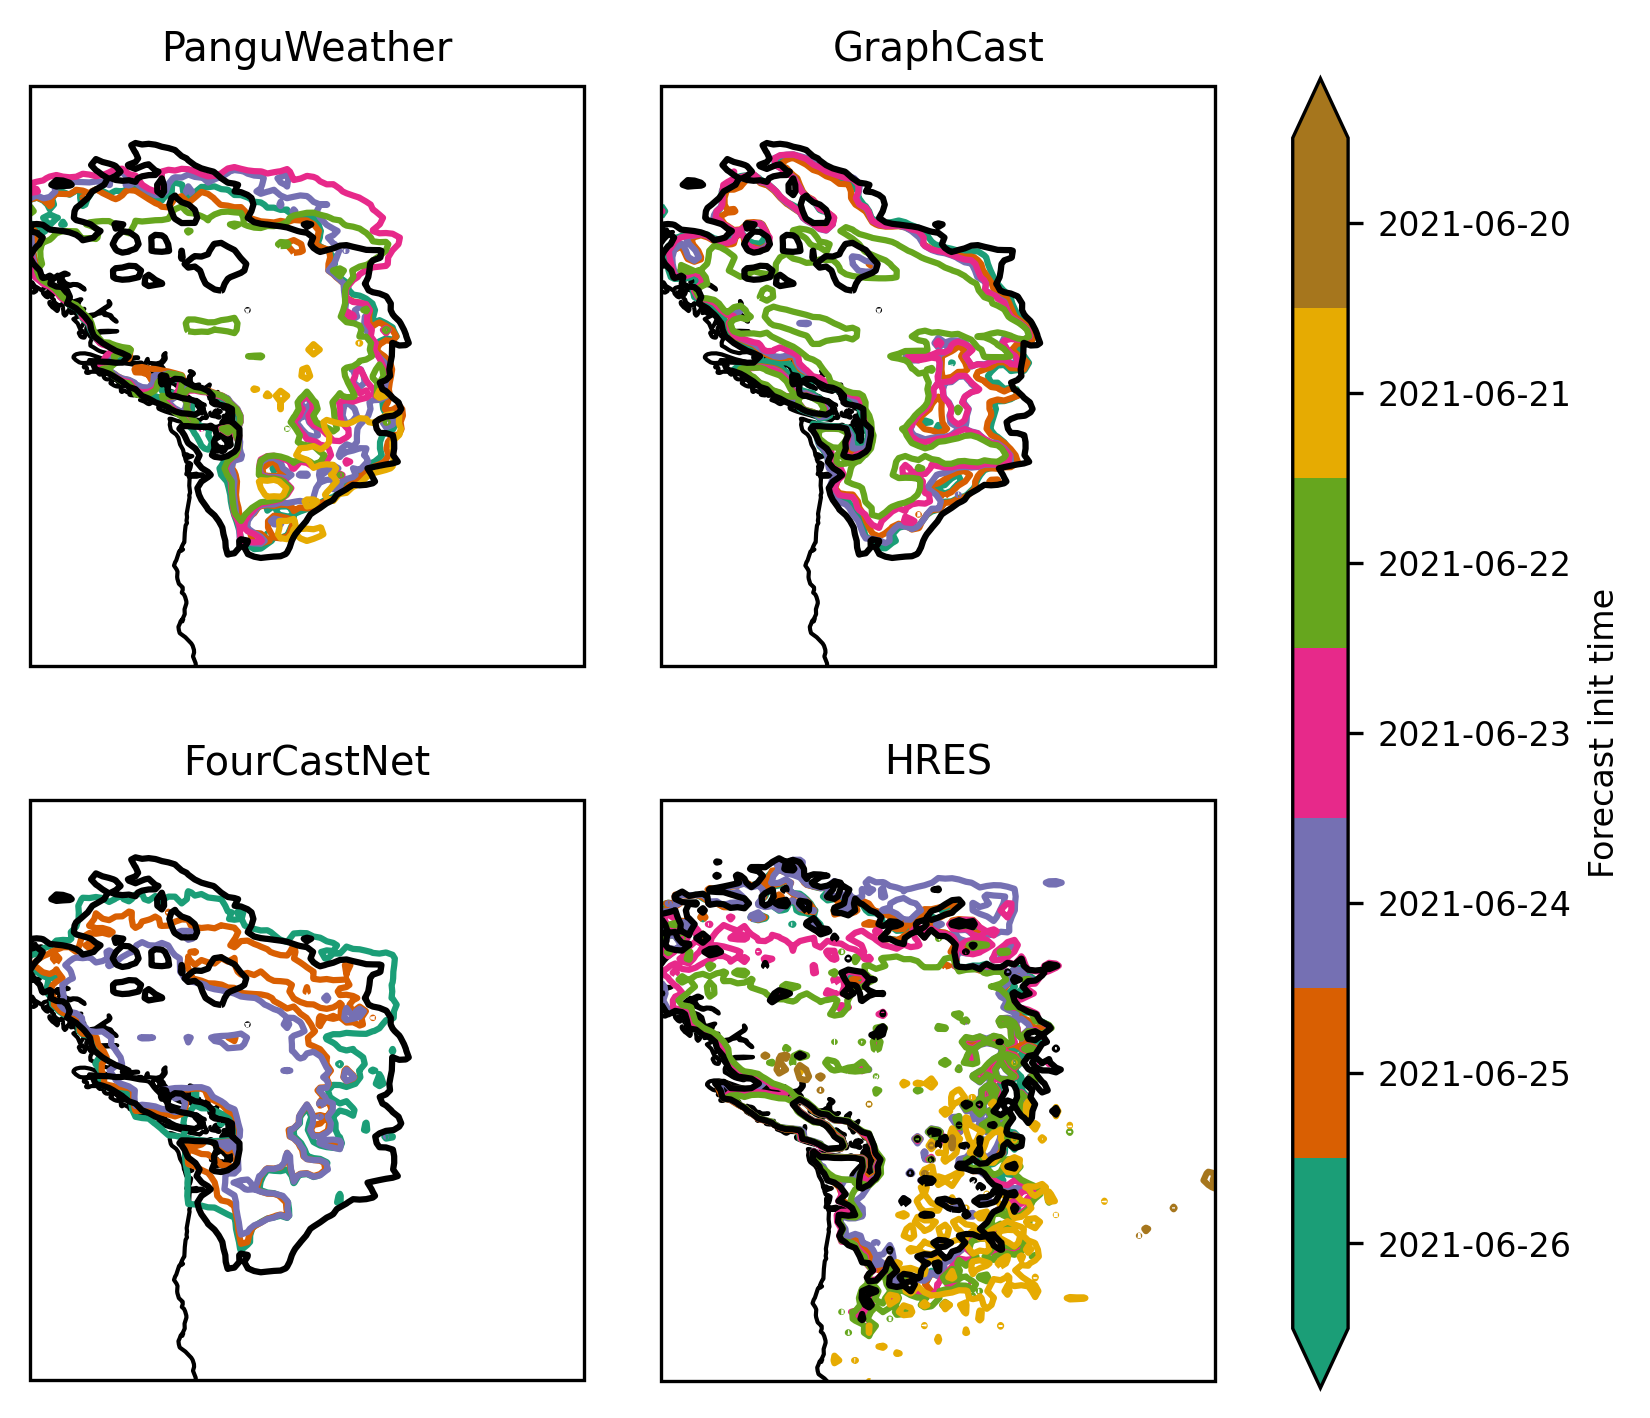

In [21]:
aspect_ratio_single_plot = 1
fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot))
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.1])

for j, fc in enumerate(fc_data.forecast):
    ax = fig.add_subplot(gs[j // 2, j % 2], projection=ccrs.PlateCarree())
    for i, start_date in enumerate(start_dates):
        anomaly.sel({"forecast": fc, "start_date": start_date}).plot.contour(
            ax=ax, add_colorbar=False, levels=[threshold], colors=[colors[i]]
        )

    if fc == "HRES":
        anomaly_hres_t0.mean(dim=("dayofyear", "hour"))["2m_temperature"].plot.contour(
            ax=ax, levels=[threshold], colors=["k"]
        )
    else:
        anomaly_ERA5.mean(dim=("dayofyear", "hour"))["2m_temperature"].plot.contour(
            ax=ax, levels=[threshold], colors=["k"]
        )
    ax.set_title(fc.values)
    ax.coastlines()

ax_cbar = fig.add_subplot(gs[:, -1])

cbar = plt.colorbar(
    sm,
    cax=ax_cbar,
    ticks=ticks,
    label=r"Forecast init time",
    orientation="vertical",
    extend="both",
)
cbar.set_ticklabels(cbar_labels)

plt.savefig("images/2021_PNW_heatwave_contour_evolution.png")

# combine time series and contour plots:

In [22]:
cmap = plt.cm.cividis  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

bounds = np.linspace(0, 100, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sm = ScalarMappable(cmap=cmap, norm=norm)

/tmp/ipykernel_3513969/1628639715.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


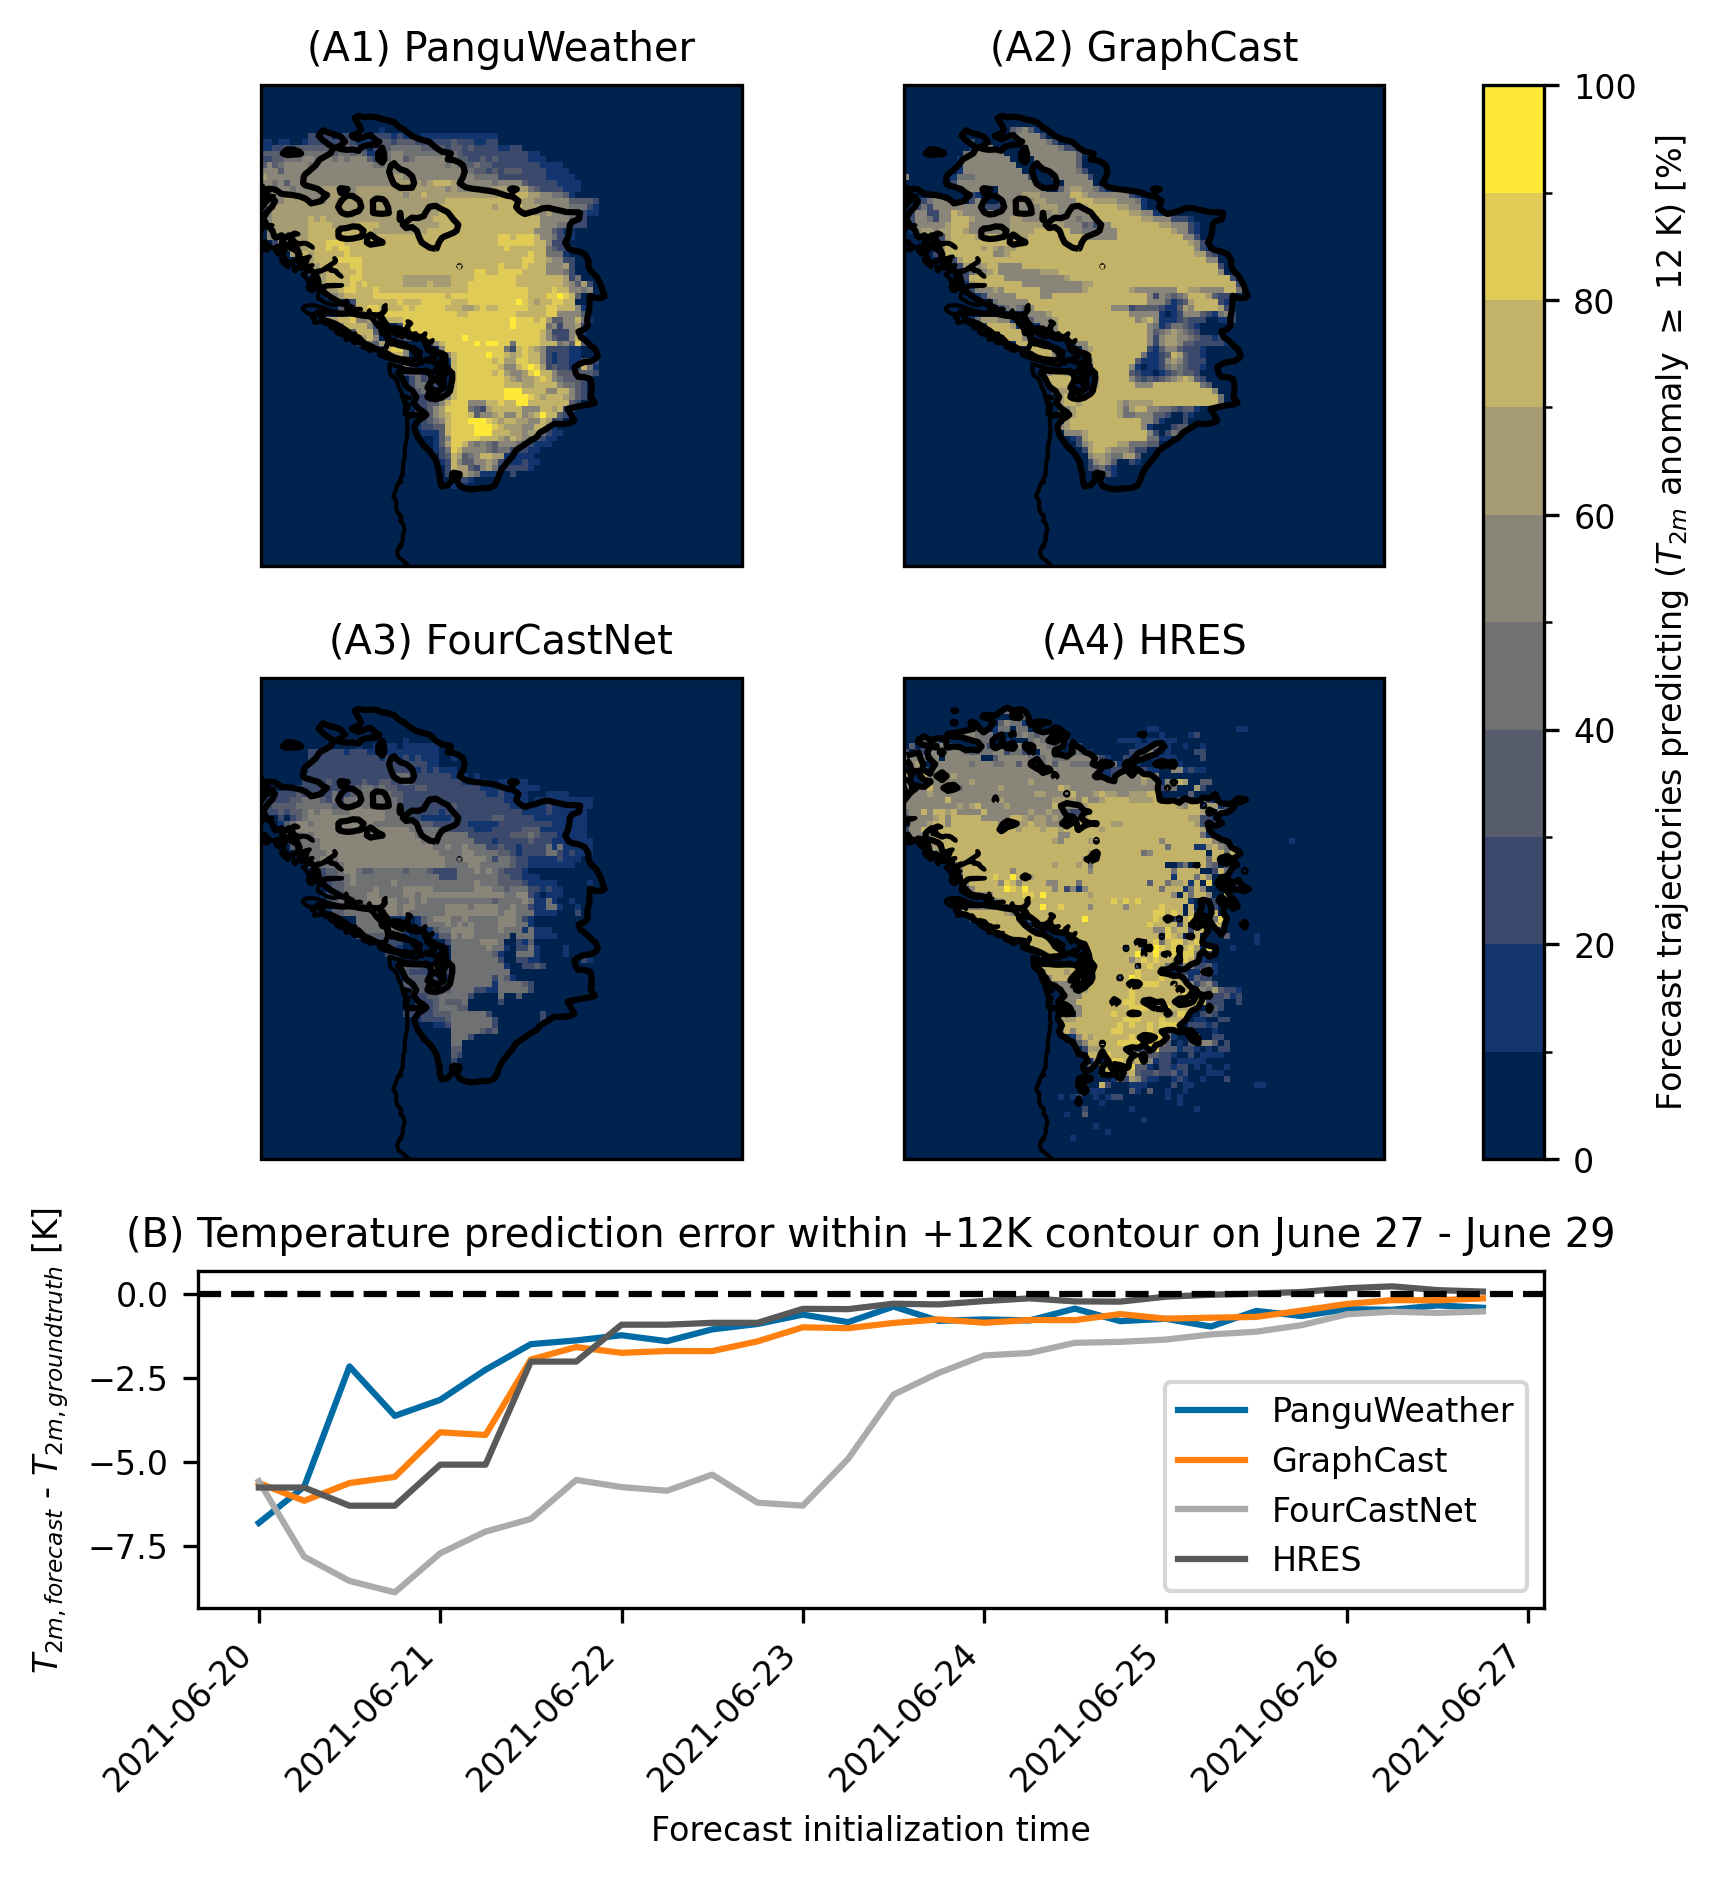

In [23]:
aspect_ratio_single_plot = 0.9
fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot))
gs = gridspec.GridSpec(
    3, 3, figure=fig, width_ratios=[1, 1, 0.1], height_ratios=[1, 1, 0.7]
)

for j, fc in enumerate(fc_data.forecast):
    ax = fig.add_subplot(gs[j // 2, j % 2], projection=ccrs.PlateCarree())

    (
        100
        * (anomaly >= threshold).sum("start_date").sel(forecast=fc)
        / len(anomaly.start_date)
    ).plot(cmap=cmap, norm=norm, add_colorbar=False)  # cbar_kwargs=dict(ticks=ticks)

    if fc == "HRES":
        anomaly_hres_t0.mean(dim=("dayofyear", "hour"))["2m_temperature"].plot.contour(
            ax=ax, levels=[threshold], colors=["k"]
        )
    else:
        anomaly_ERA5.mean(dim=("dayofyear", "hour"))["2m_temperature"].plot.contour(
            ax=ax, levels=[threshold], colors=["k"]
        )
    ax.set_title(f"(A{j+1}) " + str(fc.values))
    ax.coastlines()

ax_cbar = fig.add_subplot(gs[:-1, -1])

plt.colorbar(
    sm,
    cax=ax_cbar,
    label=r"Forecast trajectories predicting ($T_{2m}$ anomaly $\geq$ 12 K) [%]",
    orientation="vertical",
    extend="neither",
)


# time series:
start_dates = ts.start - np.arange(1, 29) * np.timedelta64(6, "h")

ax = fig.add_subplot(gs[-1, :])

for fc in m_fcs.forecast:
    ax.plot(
        start_dates,
        m_fcs.sel(forecast=fc) - gts[fc_to_gt[fc.to_numpy().item()]],
        label=fc.to_numpy(),
    )

ax.axhline(0, color="k", linestyle="dashed")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_xlabel("Forecast initialization time")
ax.set_ylabel("$T_{2m, forecast}$ - $T_{2m, ground truth}$ [K]")

ax.set_title(
    f"(B) Temperature prediction error within +{threshold}K contour on June 27 - June 29"
)

ax.legend(loc="best")

plt.tight_layout()


plt.savefig("images/2021_PNW_heatwave_combined_contour_timeseries.png")